# Implementing the Mass Transport Approach for Discrete Choice Models


_Thomas Wiemann_

_TA Discussion \# 6_  
_ECON 31740_  

_Feburary 21, 2022_  

## Section 0: Preliminaries

This section loads the necessary dependencies. The mass transport approach is implemented in a custom package, ``MyMethods.jl``, which is readily available via https://github.com/thomaswiemann/MyMethods.jl. (See the ``README.md`` for installation instructions.) 

In [2]:
# Load custom package for basis functions. If not yet installed, run the following:
#    ``using Pkg; Pkg.add(PackageSpec(url="https://github.com/thomaswiemann/MyMethods.jl")))``.
using MyMethods

# Load additional dependencies
using Distributions, BenchmarkTools
using Plots, LaTeXStrings

In [46]:
# Generate example data and calculate conditional choice probabilities 
J = 3
x = collect(1:1:10)
T = length(x)
mu = zeros((T, J))

mu[:, 1] .= 0
mu[:, 2] = 1 .+ sqrt.(x)
mu[:, 3] = log.(x)

mu = exp.(mu)
CCP = mu ./ (sum(mu, dims = 2))    

10×3 Matrix{Float64}:
 0.106507   0.786986  0.106507
 0.070517   0.788449  0.141034
 0.0516413  0.793435  0.154924
 0.0398636  0.800682  0.159454
 0.0318132  0.809121  0.159066
 0.0259846  0.818108  0.155908
 0.0215929  0.827257  0.15115
 0.0181851  0.836334  0.145481
 0.0154803  0.845197  0.139323
 0.0132948  0.853758  0.132948

In [47]:
# Define error distribution
Q = GeneralizedExtremeValue(-0.57721, 1, 0)

GeneralizedExtremeValue{Float64}(μ=-0.57721, σ=1.0, ξ=0.0)

In [48]:
# First indetermancy issue
n_sim = 100
S_mat = collect(1:1:10)
bounds = zeros((J, 2, length(S_mat)))
for s in 1:length(S_mat)
    # Draw latent utility shocks
    ϵ_s = rand(Q, (J, maximum(S_mat)))
    for k in 1:n_sim
        # Estimate w via mass transport approach
        mta_fit_s = myMTA(CCP[10, :], ϵ = ϵ_s[:, 1:S_mat[s]])

        # Estimate bounds on w 
        bounds_s = get_mtabounds(mta_fit_s)

        # Store results
        bounds[:, :, s] = bounds[:, :, s] + bounds_s
    end    
end
bounds = bounds ./ n_sim;

In [49]:
bounds[:, 2, :] .- bounds[:, 1, :]

3×10 Matrix{Float64}:
 0.0           0.0          0.0          …  0.0           0.0
 3.21965e-15  -1.95399e-14  8.43769e-15     1.57652e-14  -4.17444e-14
 1.33227e-15  -3.37508e-14  1.40998e-14     2.66454e-14  -4.85167e-14

In [50]:
n_sim = 100

100

In [116]:
@btime mta_fit = myMTA(CCP[1, :], Q = Q, S = 1000)

  215.073 ms (116243 allocations: 7.72 MiB)


myMTA([-0.0, 2.016450095589022, 0.12295584888410382], [0.10650697891920075, 0.7869860421615985, 0.10650697891920075], GeneralizedExtremeValue{Float64}(μ=-0.57721, σ=1.0, ξ=0.0), 1000, 0.688658701292739, [-0.6146108278845254 -1.2494638944612175 … -0.9659648783095726 2.998127725783435; -0.6848096212364355 -1.4675242532415935 … -1.287029160833402 -0.2364149826501199; -0.6052902405568428 -0.3109623243867106 … 0.39834192310229766 6.237168650040424], A JuMP Model
Minimization problem with:
Variables: 1003
Objective function type: JuMP.AffExpr
`JuMP.AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`JuMP.AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 3000 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: GLPK
Names registered in the model: c, w0, z, λ)

In [51]:
w_mat = zeros((J, T, n_sim))
for t in 1:T
    for s in 1:n_sim
        # Estimate w via mass transport approach
        mta_fit_t = myMTA(CCP[t, :], Q = Q, S = 1000)

        # Store results
        w_mat[:, t, s] = mta_fit_t.w
    end
end

In [54]:
w_coefs = mapslices(mean, w_mat, dims = 3)[:, :, 1]

3×10 Matrix{Float64}:
 0.0        0.0       0.0      0.0      …  0.0      0.0      0.0      0.0
 2.00277    2.43663   2.70772  3.01425     3.60226  3.77493  4.01095  4.13147
 0.0161423  0.713511  1.07587  1.39843     1.90441  2.03692  2.204    2.2646

In [63]:
w_q10 = mapslices(x -> quantile(x, 0.1), w_mat, dims = 3)[:, :, 1]
w_q90 = mapslices(x -> quantile(x, 0.9), w_mat, dims = 3)[:, :, 1]

3×10 Matrix{Float64}:
 0.0       0.0       0.0      0.0      …  0.0      0.0      0.0      0.0
 2.15919   2.60731   2.8667   3.18709     3.83217  4.03826  4.30944  4.48205
 0.197219  0.914526  1.25684  1.62562     2.13414  2.3008   2.55511  2.62619

In [60]:
quantile(w_mat[2, 1, :], 0.1)

1.8784488815784504

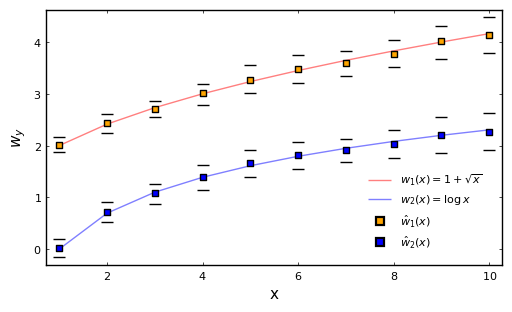

In [115]:
# Initialize plot
pyplot(size=(500,300), leg=true);

# Plot parameters
plt=plot(x, log.(mu[:, 2]), line = (:line, :line, 0.5, 1, :red), label=L"$w_1(x)=1+\sqrt{x}$")
plot!(x, log.(mu[:, 3]), line = (:line, :line, 0.5, 1, :blue), label=L"$w_2(x)=\log x$")
plot!(x, w_coefs[2, :], seriestype = :scatter, markershape=:rect, markersize=4, color=:orange, label=L"$\hat{w}_1(x)$")
plot!(x, w_coefs[3, :], seriestype = :scatter, markershape=:rect, markersize=4, color=:blue, label=L"$\hat{w}_2(x)$")
plot!(x, w_q10[2, :], seriestype = :scatter, markershape=:hline, markersize=9, color=:black, label="")
plot!(x, w_q90[2, :], seriestype = :scatter, markershape=:hline, markersize=9, color=:black, label="")
plot!(x, w_q10[3, :], seriestype = :scatter, markershape=:hline, markersize=9, color=:black, label="")
plot!(x, w_q90[3, :], seriestype = :scatter, markershape=:hline, markersize=9, color=:black, label="")

# Additional formatting
plot!(legend=(0.675,0), framestyle = :box, grid=false, 
    background_color_legend = nothing)
ylabel!(L"$w_y$")
xlabel!("x")

# Save as pdf
savefig(plt,"mta_plot.pdf")

In [ ]:
bounds

In [ ]:
w_mat = zeros((J, T))
for t in 1:T
    # Estimate w via mass transport approach
    mta_fit_t = myMTA(CCP[t, :], Q, S = 1000)
    
    # Estimate bounds on w 
    bounds_t = get_mtabounds(mta_fit_t)
    
    # Store results
    w_mat[:, t] = mta_fit_t.w
end

In [ ]:
w_mat

## Section 1: A Most Simple Example

This section generates conditional choice probabilities of $J=3$ products in $T=100$ markets, with product-market specific characteristics $x_{jt}\in\mathbf{R}^2$. 

The true coefficients are 
$$
\alpha_0 = [1, 2, 3], \qquad \beta_0 = [1, -1].
$$

In [ ]:
# Set dimensions of the data
T = 100;
J = 3;

# Generate example data and calculate conditional choice probabilities 
X = randn((T, J, 2))
mu = zeros((T, J))
for j in 1:(J )
    mu[:, j] = j .+ X[:, j, :] * [1, -1]
end
mu = exp.(mu)
CCP = mu ./ (1 .+ sum(mu, dims = 2));

We will attempt to recover these via the mass transport approach where we select the true distribution of the latent utility shocks ($\varepsilon \sim $T1EV).

In [ ]:
# Define error distribution (T1EV)
Q = GeneralizedExtremeValue(-0.57721, 1, 0)

# Estimate and benchmark the mass transport problem
@btime mta_fit = myMTA(CCP, X, Q; S = 100);

The estimated intercepts are reasonably aligned with $\alpha_0$,

In [ ]:
# Check the intercept coefficients
α_hat = mta_fit.α

Similarly, the slope coefficients are accurately estimated.

In [ ]:
β_hat = mta_fit.β